In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

fulldataset = datasets.CIFAR10(root="/kaggle/working/cifar10", train=True, download=True, transform=train_transform)

traininglength = int(0.7 * len(fulldataset))
validationlength = len(fulldataset) - traininglength
trainingset, validationset = random_split(fulldataset, [traininglength, validationlength])

validationset.dataset = datasets.CIFAR10(root="/kaggle/working/cifar10", train=True, download=False, transform=test_transform)

testingdataset = datasets.CIFAR10(root="/kaggle/working/cifar10", train=False, download=True, transform=test_transform)

trainingloader = DataLoader(trainingset, batch_size=64, shuffle=True)
validationloader = DataLoader(validationset, batch_size=64, shuffle=False)
testingloader = DataLoader(testingdataset, batch_size=64, shuffle=False)

In [3]:
class OD_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(OD_CNN, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.3),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OD_CNN(num_classes=10).to(device)

In [5]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [6]:
totalepochs = 60
traininglosslist = []
validationlosslist = []

for epoch in range(totalepochs):
    model.train()
    Loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(trainingloader, desc=f"Epoch {epoch+1}/{totalepochs} - Training"):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        Loss += loss.item()
        _, prediction = torch.max(output, 1)
        match = (prediction == labels)
        matchcount = match.sum()
        correct += matchcount.item()  
        total += labels.size(0)

    trainingloss = Loss / len(trainingloader)
    trainingaccuracy = correct / total
    traininglosslist.append(trainingloss)

    model.eval()
    validationloss = 0.0
    correctvalidation = 0
    totalvalidation = 0
    with torch.no_grad():
        for images, labels in tqdm(validationloader, desc=f"Epoch {epoch+1}/{totalepochs} - Validation"):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            validationloss += loss.item()
            
            _, prediction = torch.max(output, 1)
            match = (prediction == labels) 
            matchcount = match.sum()
            correctvalidation += matchcount.item()
            totalvalidation += labels.size(0)

    valloss = validationloss / len(validationloader)
    validationaccuracy = correctvalidation / totalvalidation
    validationlosslist.append(valloss)

    scheduler.step()

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {trainingloss:.4f}, Train Accuracy = {trainingaccuracy:.4f}, "
          f"Validation Loss = {valloss:.4f}, Validation Accuracy = {validationaccuracy:.4f}")

Epoch 1/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.87it/s]


Epoch 1: Train Loss = 1.8016, Train Accuracy = 0.3891, Validation Loss = 1.5789, Validation Accuracy = 0.4993


Epoch 2/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.94it/s]


Epoch 2: Train Loss = 1.5562, Train Accuracy = 0.5119, Validation Loss = 1.3427, Validation Accuracy = 0.6191


Epoch 3/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.96it/s]


Epoch 3: Train Loss = 1.4334, Train Accuracy = 0.5789, Validation Loss = 1.2807, Validation Accuracy = 0.6615


Epoch 4/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.98it/s]


Epoch 4: Train Loss = 1.3600, Train Accuracy = 0.6152, Validation Loss = 1.1997, Validation Accuracy = 0.6988


Epoch 5/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.11it/s]


Epoch 5: Train Loss = 1.3025, Train Accuracy = 0.6423, Validation Loss = 1.1268, Validation Accuracy = 0.7331


Epoch 6/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.58it/s]


Epoch 6: Train Loss = 1.2551, Train Accuracy = 0.6698, Validation Loss = 1.0842, Validation Accuracy = 0.7506


Epoch 7/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.24it/s]


Epoch 7: Train Loss = 1.2179, Train Accuracy = 0.6898, Validation Loss = 1.0896, Validation Accuracy = 0.7507


Epoch 8/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.71it/s]


Epoch 8: Train Loss = 1.1918, Train Accuracy = 0.7000, Validation Loss = 1.0534, Validation Accuracy = 0.7676


Epoch 9/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.46it/s]


Epoch 9: Train Loss = 1.1619, Train Accuracy = 0.7141, Validation Loss = 1.0306, Validation Accuracy = 0.7770


Epoch 10/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.71it/s]


Epoch 10: Train Loss = 1.1436, Train Accuracy = 0.7220, Validation Loss = 1.0166, Validation Accuracy = 0.7848


Epoch 11/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.39it/s]


Epoch 11: Train Loss = 1.0761, Train Accuracy = 0.7557, Validation Loss = 0.9371, Validation Accuracy = 0.8204


Epoch 12/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.15it/s]


Epoch 12: Train Loss = 1.0519, Train Accuracy = 0.7664, Validation Loss = 0.9265, Validation Accuracy = 0.8263


Epoch 13/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.49it/s]


Epoch 13: Train Loss = 1.0347, Train Accuracy = 0.7757, Validation Loss = 0.9089, Validation Accuracy = 0.8341


Epoch 14/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.82it/s]


Epoch 14: Train Loss = 1.0255, Train Accuracy = 0.7799, Validation Loss = 0.9023, Validation Accuracy = 0.8403


Epoch 15/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.90it/s]


Epoch 15: Train Loss = 1.0145, Train Accuracy = 0.7863, Validation Loss = 0.9000, Validation Accuracy = 0.8393


Epoch 16/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.57it/s]


Epoch 16: Train Loss = 0.9972, Train Accuracy = 0.7917, Validation Loss = 0.8962, Validation Accuracy = 0.8397


Epoch 17/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.64it/s]


Epoch 17: Train Loss = 0.9928, Train Accuracy = 0.7964, Validation Loss = 0.8923, Validation Accuracy = 0.8410


Epoch 18/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.65it/s]


Epoch 18: Train Loss = 0.9892, Train Accuracy = 0.7971, Validation Loss = 0.8691, Validation Accuracy = 0.8530


Epoch 19/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.25it/s]


Epoch 19: Train Loss = 0.9779, Train Accuracy = 0.8016, Validation Loss = 0.8625, Validation Accuracy = 0.8557


Epoch 20/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.19it/s]


Epoch 20: Train Loss = 0.9696, Train Accuracy = 0.8082, Validation Loss = 0.8730, Validation Accuracy = 0.8497


Epoch 21/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.39it/s]


Epoch 21: Train Loss = 0.9337, Train Accuracy = 0.8202, Validation Loss = 0.8317, Validation Accuracy = 0.8690


Epoch 22/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.31it/s]


Epoch 22: Train Loss = 0.9119, Train Accuracy = 0.8346, Validation Loss = 0.8328, Validation Accuracy = 0.8678


Epoch 23/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.91it/s]


Epoch 23: Train Loss = 0.9078, Train Accuracy = 0.8357, Validation Loss = 0.8248, Validation Accuracy = 0.8727


Epoch 24/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.80it/s]


Epoch 24: Train Loss = 0.9015, Train Accuracy = 0.8370, Validation Loss = 0.8182, Validation Accuracy = 0.8723


Epoch 25/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.23it/s]


Epoch 25: Train Loss = 0.8936, Train Accuracy = 0.8408, Validation Loss = 0.8175, Validation Accuracy = 0.8729


Epoch 26/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.17it/s]


Epoch 26: Train Loss = 0.8868, Train Accuracy = 0.8456, Validation Loss = 0.8159, Validation Accuracy = 0.8755


Epoch 27/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.30it/s]


Epoch 27: Train Loss = 0.8858, Train Accuracy = 0.8459, Validation Loss = 0.8112, Validation Accuracy = 0.8739


Epoch 28/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.39it/s]


Epoch 28: Train Loss = 0.8777, Train Accuracy = 0.8471, Validation Loss = 0.8067, Validation Accuracy = 0.8777


Epoch 29/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.79it/s]


Epoch 29: Train Loss = 0.8808, Train Accuracy = 0.8475, Validation Loss = 0.8102, Validation Accuracy = 0.8757


Epoch 30/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.48it/s]


Epoch 30: Train Loss = 0.8744, Train Accuracy = 0.8477, Validation Loss = 0.7986, Validation Accuracy = 0.8832


Epoch 31/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.82it/s]


Epoch 31: Train Loss = 0.8491, Train Accuracy = 0.8608, Validation Loss = 0.7855, Validation Accuracy = 0.8870


Epoch 32/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.01it/s]


Epoch 32: Train Loss = 0.8424, Train Accuracy = 0.8645, Validation Loss = 0.7884, Validation Accuracy = 0.8853


Epoch 33/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.81it/s]


Epoch 33: Train Loss = 0.8401, Train Accuracy = 0.8654, Validation Loss = 0.7869, Validation Accuracy = 0.8863


Epoch 34/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.02it/s]


Epoch 34: Train Loss = 0.8342, Train Accuracy = 0.8680, Validation Loss = 0.7814, Validation Accuracy = 0.8913


Epoch 35/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.97it/s]


Epoch 35: Train Loss = 0.8326, Train Accuracy = 0.8702, Validation Loss = 0.7782, Validation Accuracy = 0.8915


Epoch 36/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.59it/s]


Epoch 36: Train Loss = 0.8292, Train Accuracy = 0.8705, Validation Loss = 0.7730, Validation Accuracy = 0.8949


Epoch 37/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.42it/s]


Epoch 37: Train Loss = 0.8233, Train Accuracy = 0.8734, Validation Loss = 0.7795, Validation Accuracy = 0.8910


Epoch 38/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.79it/s]


Epoch 38: Train Loss = 0.8189, Train Accuracy = 0.8753, Validation Loss = 0.7746, Validation Accuracy = 0.8945


Epoch 39/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.17it/s]


Epoch 39: Train Loss = 0.8209, Train Accuracy = 0.8743, Validation Loss = 0.7756, Validation Accuracy = 0.8936


Epoch 40/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.99it/s]


Epoch 40: Train Loss = 0.8178, Train Accuracy = 0.8767, Validation Loss = 0.7748, Validation Accuracy = 0.8931


Epoch 41/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.01it/s]


Epoch 41: Train Loss = 0.8027, Train Accuracy = 0.8819, Validation Loss = 0.7647, Validation Accuracy = 0.8980


Epoch 42/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.53it/s]


Epoch 42: Train Loss = 0.8008, Train Accuracy = 0.8833, Validation Loss = 0.7663, Validation Accuracy = 0.8978


Epoch 43/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.62it/s]


Epoch 43: Train Loss = 0.7999, Train Accuracy = 0.8845, Validation Loss = 0.7626, Validation Accuracy = 0.8978


Epoch 44/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.00it/s]


Epoch 44: Train Loss = 0.7929, Train Accuracy = 0.8869, Validation Loss = 0.7606, Validation Accuracy = 0.8985


Epoch 45/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 84.37it/s]


Epoch 45: Train Loss = 0.7949, Train Accuracy = 0.8857, Validation Loss = 0.7624, Validation Accuracy = 0.8991


Epoch 46/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.79it/s]


Epoch 46: Train Loss = 0.7928, Train Accuracy = 0.8880, Validation Loss = 0.7596, Validation Accuracy = 0.8997


Epoch 47/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.26it/s]


Epoch 47: Train Loss = 0.7889, Train Accuracy = 0.8889, Validation Loss = 0.7595, Validation Accuracy = 0.9007


Epoch 48/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.51it/s]


Epoch 48: Train Loss = 0.7879, Train Accuracy = 0.8893, Validation Loss = 0.7573, Validation Accuracy = 0.8998


Epoch 49/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 84.84it/s]


Epoch 49: Train Loss = 0.7860, Train Accuracy = 0.8922, Validation Loss = 0.7591, Validation Accuracy = 0.8994


Epoch 50/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.78it/s]


Epoch 50: Train Loss = 0.7819, Train Accuracy = 0.8927, Validation Loss = 0.7588, Validation Accuracy = 0.8989


Epoch 51/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.97it/s]


Epoch 51: Train Loss = 0.7808, Train Accuracy = 0.8946, Validation Loss = 0.7541, Validation Accuracy = 0.9008


Epoch 52/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.90it/s]


Epoch 52: Train Loss = 0.7804, Train Accuracy = 0.8925, Validation Loss = 0.7538, Validation Accuracy = 0.9015


Epoch 53/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.81it/s]


Epoch 53: Train Loss = 0.7754, Train Accuracy = 0.8971, Validation Loss = 0.7549, Validation Accuracy = 0.9021


Epoch 54/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.57it/s]


Epoch 54: Train Loss = 0.7769, Train Accuracy = 0.8941, Validation Loss = 0.7556, Validation Accuracy = 0.9006


Epoch 55/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.36it/s]


Epoch 55: Train Loss = 0.7724, Train Accuracy = 0.8985, Validation Loss = 0.7544, Validation Accuracy = 0.9013


Epoch 56/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.84it/s]


Epoch 56: Train Loss = 0.7751, Train Accuracy = 0.8957, Validation Loss = 0.7540, Validation Accuracy = 0.9015


Epoch 57/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.68it/s]


Epoch 57: Train Loss = 0.7705, Train Accuracy = 0.8972, Validation Loss = 0.7543, Validation Accuracy = 0.9018


Epoch 58/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.47it/s]


Epoch 58: Train Loss = 0.7657, Train Accuracy = 0.9017, Validation Loss = 0.7512, Validation Accuracy = 0.9037


Epoch 59/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.75it/s]


Epoch 59: Train Loss = 0.7703, Train Accuracy = 0.8986, Validation Loss = 0.7481, Validation Accuracy = 0.9049


Epoch 60/60 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.31it/s]

Epoch 60: Train Loss = 0.7681, Train Accuracy = 0.9000, Validation Loss = 0.7497, Validation Accuracy = 0.9030


In [27]:
def testdataset(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    allpredictions = []
    alltargets = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)

            total += labels.size(0)
            match = (predicted == labels)
            matchcount = match.sum()
            correct += matchcount.item() 

            p = predicted.cpu().numpy()
            q = labels.cpu().numpy()
            allpredictions.extend(p)
            alltargets.extend(q)

    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    
testdataset(model, testingloader, device)

Testing: 100%|██████████| 157/157 [00:01<00:00, 88.78it/s]


Test Accuracy: 89.82%


In [13]:
torch.save(model.state_dict(), 'weight.pth')

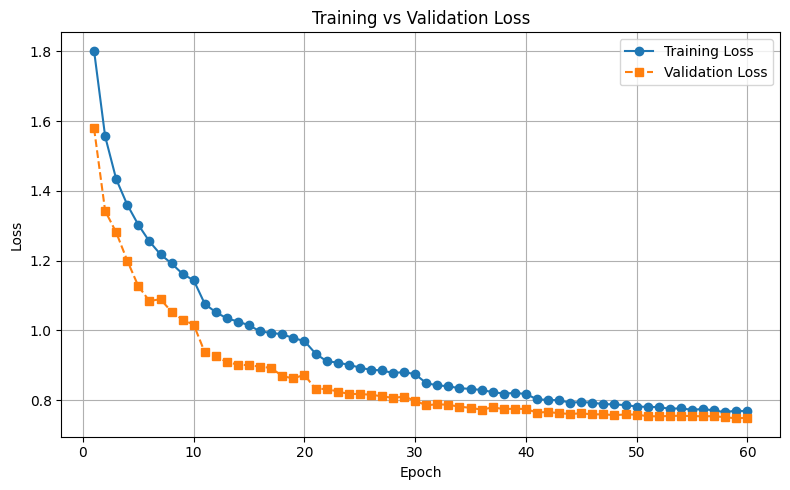

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, totalepochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, traininglosslist, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validationlosslist, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
